In [1]:
# https://www.kaggle.com/datasets/uciml/pima-indians-diabetes-database

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv("16-diabetes.csv")

In [4]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [6]:
df.isnull().sum().sum()

np.int64(0)

In [7]:
df.duplicated().sum()

np.int64(0)

In [8]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [9]:
# Some columns min is 0 but impossible so, we'll check that columns

In [10]:
columns_to_check = ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]

for col in columns_to_check:
    zero_count = (df[col] == 0).sum()
    zero_percentage = 100 * zero_count / len(df)
    print(f"{col}: {zero_count} %{zero_percentage:.2f}")

Glucose: 5 %0.65
BloodPressure: 35 %4.56
SkinThickness: 227 %29.56
Insulin: 374 %48.70
BMI: 11 %1.43


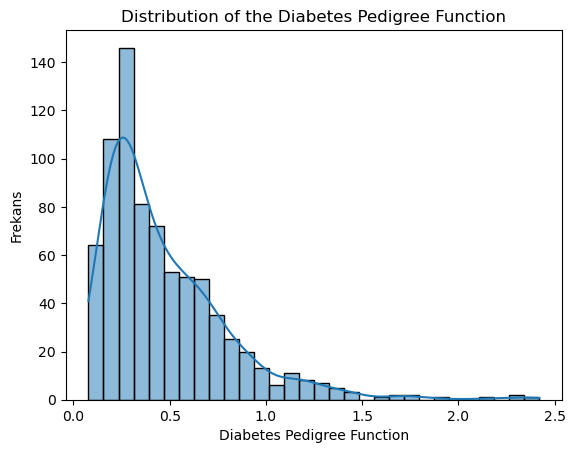

In [11]:
sns.histplot(df["DiabetesPedigreeFunction"], bins=30, kde=True)
plt.title('Distribution of the Diabetes Pedigree Function')
plt.xlabel('Diabetes Pedigree Function')
plt.ylabel('Frekans')
plt.show()

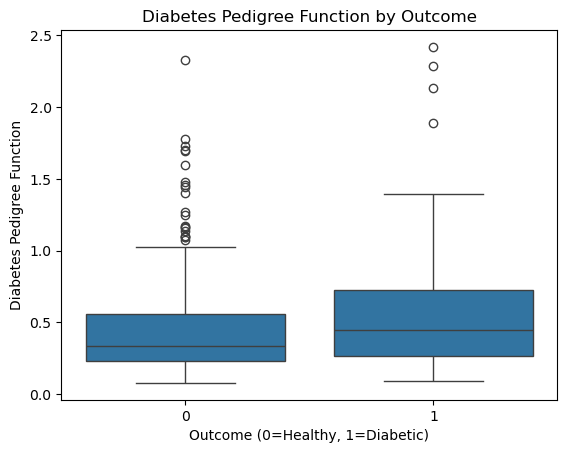

In [12]:
sns.boxplot(x='Outcome', y='DiabetesPedigreeFunction', data=df)
plt.title('Diabetes Pedigree Function by Outcome')
plt.xlabel('Outcome (0=Healthy, 1=Diabetic)')
plt.ylabel('Diabetes Pedigree Function')
plt.show()

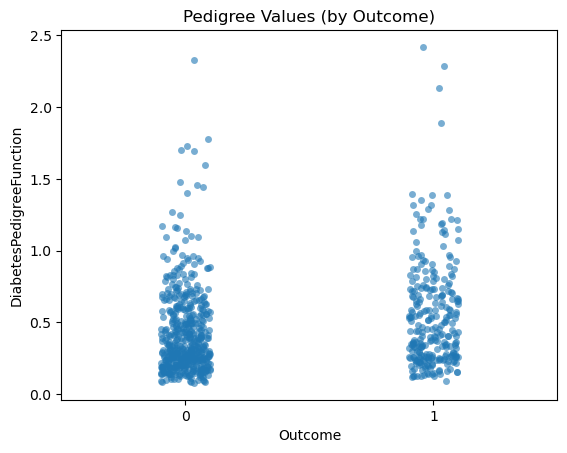

In [13]:
sns.stripplot(x='Outcome', y='DiabetesPedigreeFunction', data=df, jitter=True, alpha=0.6)
plt.title('Pedigree Values (by Outcome)')
plt.show()

In this study, two preprocessing strategies were applied to medical columns with a minimum value of 0 (e.g., insulin, Glucose,BloodPressure,SkinThickness,BMI), as such values are physiologically implausible and considered missing data.

1. **Median Imputation**: Zero values were replaced with the median of the non-zero values in each column.
2. **Row Removal**: Rows containing zero values in the relevant columns were removed from the dataset.

Separate models were built for each approach, followed by hyperparameter tuning and performance comparison.

In [14]:
df1 = df.copy()

In [15]:
df1.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


## Independent & Dependent Features

In [17]:
X = df.drop("Outcome", axis=1)
y = df["Outcome"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=15)

In [18]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((614, 8), (154, 8), (614,), (154,))

## Encoding

For columns where the minimum value cannot be zero, we will replace the zero values with the median of the remaining (non-zero) values

In [19]:
columns_to_fill = ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]

In [20]:
medians = {}
for col in columns_to_fill:
    median_value = X_train[X_train[col] != 0][col].median()
    medians[col] = median_value
    X_train[col] = X_train[col].replace(0, median_value)

for col in columns_to_fill:
    X_test[col] = X_test[col].replace(0, medians[col])

In [21]:
X_train.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
304,3,150,76,29,129.5,21.0,0.207,37
297,0,126,84,29,215.0,30.7,0.520,24
522,6,114,72,29,129.5,32.3,0.189,26
618,9,112,82,24,129.5,28.2,1.282,50
501,3,84,72,32,129.5,37.2,0.267,28


In [22]:
X_test.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
343,5,122,86,29,129.5,34.7,0.290,33
728,2,175,88,29,129.5,22.9,0.326,22
73,4,129,86,20,270.0,35.1,0.231,23
254,12,92,62,7,258.0,27.6,0.926,44
741,3,102,44,20,94.0,30.8,0.400,26


In [23]:
X_train.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
count,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000
mean,3.907166,121.560261,72.612378,29.040717,142.477199,32.448208,0.469948,33.285016
std,3.385438,29.974412,12.165642,8.312217,80.879330,6.862948,0.328516,11.678337
min,0.000000,44.000000,24.000000,7.000000,14.000000,18.200000,0.084000,21.000000
25%,1.000000,100.000000,64.000000,25.000000,125.000000,27.600000,0.238250,24.000000
50%,3.000000,117.000000,72.000000,29.000000,129.500000,32.300000,0.370500,29.000000
75%,6.000000,139.750000,80.000000,32.000000,130.000000,36.500000,0.630750,40.000000
max,17.000000,199.000000,122.000000,63.000000,680.000000,67.100000,2.420000,81.000000


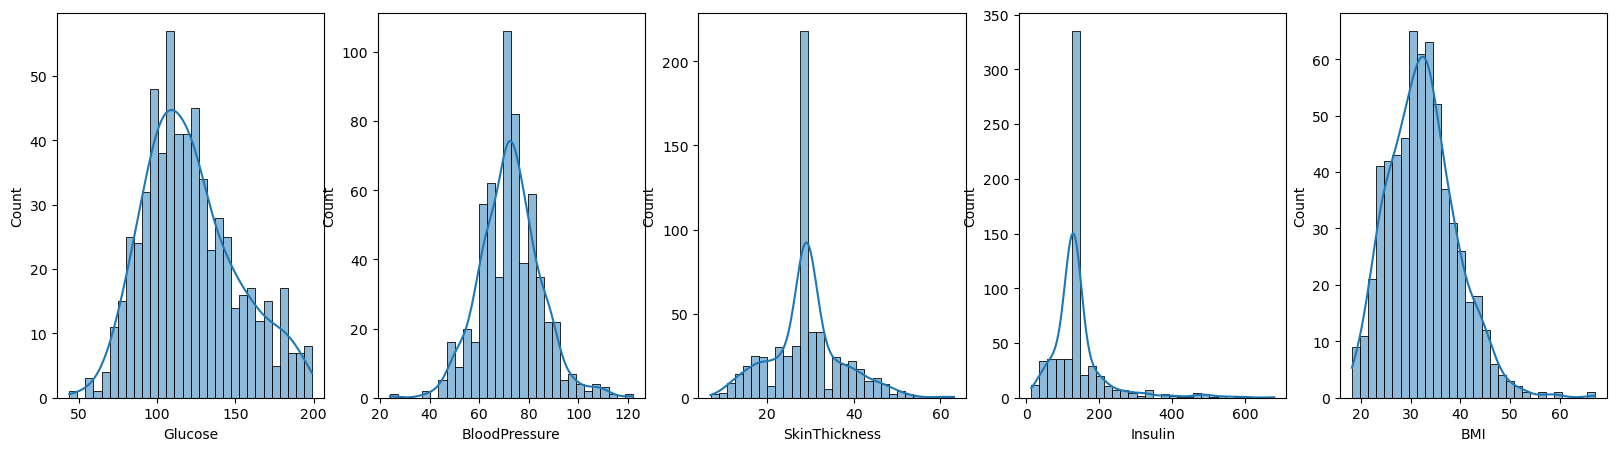

In [24]:
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(20,5))
axs = axs.flatten()

for i, col in enumerate(columns_to_fill):
    sns.histplot(X_train[col], bins=30, kde=True, ax=axs[i])
plt.show()

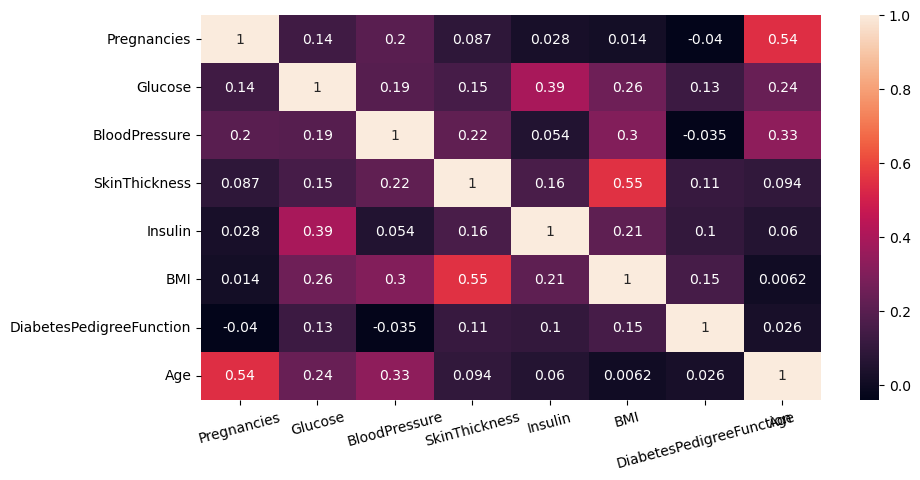

In [25]:
plt.figure(figsize=(10,5))
sns.heatmap(X_train.corr(), annot=True)
plt.xticks(rotation=15)
plt.show()

## Scaling

Scaling is important for algorithms like KNN, SVC, and Logistic Regression, but not necessary for tree-based models such as Decision Tree, Random Forest, and AdaBoost

In [26]:
from sklearn.preprocessing import StandardScaler, RobustScaler
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Classification Models

In [27]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

In [28]:
def calculate_model_metrics(true, predicted):
    acc = accuracy_score(true, predicted)
    conf_matrix = confusion_matrix(true, predicted)
    clf_report = classification_report(true, predicted) 
    
    return acc, conf_matrix, clf_report

In [29]:
models = {
    'LogisticRegression': LogisticRegression(),
    'SVC': SVC(),
    'GaussianNB': GaussianNB(),
    'KNeighborsClassifier': KNeighborsClassifier(),
    'DecisionTreeClassifier': DecisionTreeClassifier(),
    'RandomForestClassifier': RandomForestClassifier(),
    'AdaBoostClassifier': AdaBoostClassifier()
}

In [30]:
results = []

for i in range(len(list(models))):
    model = list(models.values())[i]
    model.fit(X_train, y_train)

    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    model_train_acc, model_train_conf_matrix, model_train_clf_report = calculate_model_metrics(y_train, y_train_pred)
    model_test_acc, model_test_conf_matrix, model_test_clf_report = calculate_model_metrics(y_test, y_test_pred)

    results.append(
        {
            "Model": list(models.keys())[i],
            "Train Accuracy": model_train_acc,
            "Test Accuracy": model_test_acc
        }
    )


    
    print(list(models.values())[i])

    print("Evaluation for Training Set")
    print("Accuracy Score: " ,model_train_acc)
    print("Confussion Matrix: ", model_train_conf_matrix)
    print("Classification Report: ", model_train_clf_report)

    print("--------------------------")
    

    print("Evaluation for Test Set")
    print("Accuracy Score: " ,model_test_acc)
    print("Confussion Matrix: ", model_test_conf_matrix)
    print("Classification Report: ", model_test_clf_report)

    print("--------------------------")
    print("\n")

LogisticRegression()
Evaluation for Training Set
Accuracy Score:  0.7833876221498371
Confussion Matrix:  [[347  45]
 [ 88 134]]
Classification Report:                precision    recall  f1-score   support

           0       0.80      0.89      0.84       392
           1       0.75      0.60      0.67       222

    accuracy                           0.78       614
   macro avg       0.77      0.74      0.75       614
weighted avg       0.78      0.78      0.78       614

--------------------------
Evaluation for Test Set
Accuracy Score:  0.7532467532467533
Confussion Matrix:  [[89 19]
 [19 27]]
Classification Report:                precision    recall  f1-score   support

           0       0.82      0.82      0.82       108
           1       0.59      0.59      0.59        46

    accuracy                           0.75       154
   macro avg       0.71      0.71      0.71       154
weighted avg       0.75      0.75      0.75       154

--------------------------


SVC()
Evaluatio

In [31]:
df1_results = pd.DataFrame(results)

In [32]:
df1_results.sort_values(by="Test Accuracy", ascending=False).reset_index(drop=True)

,Model,Train Accuracy,Test Accuracy
0,LogisticRegression,0.783388,0.753247
1,AdaBoostClassifier,0.786645,0.753247
2,RandomForestClassifier,1.000000,0.733766
3,SVC,0.838762,0.727273
4,GaussianNB,0.765472,0.720779
5,DecisionTreeClassifier,1.000000,0.701299
6,KNeighborsClassifier,0.830619,0.694805


## Hyperparameter Tuning

In [33]:
logistic_regression_params =  {"penalty": ["l1", "l2", "elasticnet", None], "C": [100, 10, 1, 0.1, 0.01], "solver": ["newton-cg", "lbfgs", "liblinear", "sag", "saga", "newton-cholesky"]}
svc_params = {"C": [0.1, 1, 10, 100, 1000], "kernel": ["linear", "poly", "sigmoid","rbf"], "gamma": ["scale", "auto"], "degree": [2, 3, 4]}
knn_params = {"n_neighbors": [1,3,5,7,10,15,20], "algorithm": ["auto", "ball_tree", "kd_tree", "brute"], "weights": ["uniform", "distance"], "p": [1, 2]}
decision_tree_params = {"criterion": ["gini", "entropy", "log_loss"], "splitter": ["best", "random"], "max_depth": [5,10,15,20,None],  "max_features": ["sqrt", "log2", None], "min_samples_split": [2, 5, 10]}
random_forest_params = {"max_depth": [5, 8, 15, None, 10], "max_features": ["sqrt", "log2", None], "min_samples_split": [2, 8, 15, 20], "n_estimators": [100, 200, 500, 1000]}
adaboost_params = {'n_estimators': [50, 70, 100, 120, 150, 200], 'learning_rate': [0.001, 0.01, 0.1, 1, 10]}

In [34]:
params = {
    'LogisticRegression': logistic_regression_params,
    'SVC': svc_params,
    'KNeighborsClassifier': knn_params,
    'DecisionTreeClassifier': decision_tree_params,
    'RandomForestClassifier': random_forest_params,
    'AdaBoostClassifier' : adaboost_params
}

In [35]:
best_models = {}
tuned_results = []

for name, model in models.items():
    if name in params:
        rfc = RandomizedSearchCV(model, param_distributions=params[name], cv=5, scoring='accuracy', n_jobs=-1)
        rfc.fit(X_train, y_train)

        
        best_model = rfc.best_estimator_
        best_models[name] = best_model
        
        y_train_pred = best_model.predict(X_train)
        y_test_pred = best_model.predict(X_test)
        
        model_train_ac, _,_ = calculate_model_metrics(y_train, y_train_pred)
        model_test_ac, _,_ = calculate_model_metrics(y_test, y_test_pred)

        tuned_results.append({
            "Model": name,
            "Best Params": rfc.best_params_,
            "Train Accuracy": model_train_ac,
            "Test Accuracy": model_test_ac
        })


In [36]:
df1_results_rcv = pd.DataFrame(tuned_results)

In [37]:
df1_results_rcv.sort_values(by="Test Accuracy", ascending=False).reset_index(drop=True)

,Model,Best Params,Train Accuracy,Test Accuracy
0,LogisticRegression,"{'solver': 'liblinear', 'penalty': 'l1', 'C': 1}",0.781759,0.759740
1,AdaBoostClassifier,"{'n_estimators': 120, 'learning_rate': 1}",0.815961,0.759740
2,SVC,"{'kernel': 'sigmoid', 'gamma': 'scale', 'degre...",0.765472,0.753247
3,KNeighborsClassifier,"{'weights': 'distance', 'p': 1, 'n_neighbors':...",1.000000,0.740260
4,RandomForestClassifier,"{'n_estimators': 500, 'min_samples_split': 8, ...",0.964169,0.720779
5,DecisionTreeClassifier,"{'splitter': 'best', 'min_samples_split': 10, ...",0.845277,0.714286


Based on model comparisons, Logistic Regression, AdaBoost, and SVC demonstrated balanced and consistent performance. These models maintained similar accuracy levels on both training and test data, indicating strong generalization capability.

On the other hand, Decision Tree and Random Forest achieved very high accuracy on the training data but showed a noticeable drop in test performance. This suggests that these models are prone to overfitting.

Previously, we filled the zero values in certain columns of df1 using the median. Now, we will remove the rows containing those zero values from the DataFrame and rebuild the model."

In [38]:
df2 = df.copy()

In [39]:
df2.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [40]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [41]:
df2.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [42]:
columns_to_del = ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]

In [43]:
for col in columns_to_del:
    df2 = df2.drop(df2[df2[col] == 0].index)

In [44]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 392 entries, 3 to 765
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               392 non-null    int64  
 1   Glucose                   392 non-null    int64  
 2   BloodPressure             392 non-null    int64  
 3   SkinThickness             392 non-null    int64  
 4   Insulin                   392 non-null    int64  
 5   BMI                       392 non-null    float64
 6   DiabetesPedigreeFunction  392 non-null    float64
 7   Age                       392 non-null    int64  
 8   Outcome                   392 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 30.6 KB


In [45]:
df2.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000
mean,3.301020,122.627551,70.663265,29.145408,156.056122,33.086224,0.523046,30.864796,0.331633
std,3.211424,30.860781,12.496092,10.516424,118.841690,7.027659,0.345488,10.200777,0.471401
min,0.000000,56.000000,24.000000,7.000000,14.000000,18.200000,0.085000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,21.000000,76.750000,28.400000,0.269750,23.000000,0.000000
50%,2.000000,119.000000,70.000000,29.000000,125.500000,33.200000,0.449500,27.000000,0.000000
75%,5.000000,143.000000,78.000000,37.000000,190.000000,37.100000,0.687000,36.000000,1.000000
max,17.000000,198.000000,110.000000,63.000000,846.000000,67.100000,2.420000,81.000000,1.000000


## Independent & Dependent Features 

In [46]:
X = df2.drop("Outcome", axis=1)
y = df2["Outcome"]

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=15)

In [48]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((294, 8), (98, 8), (294,), (98,))

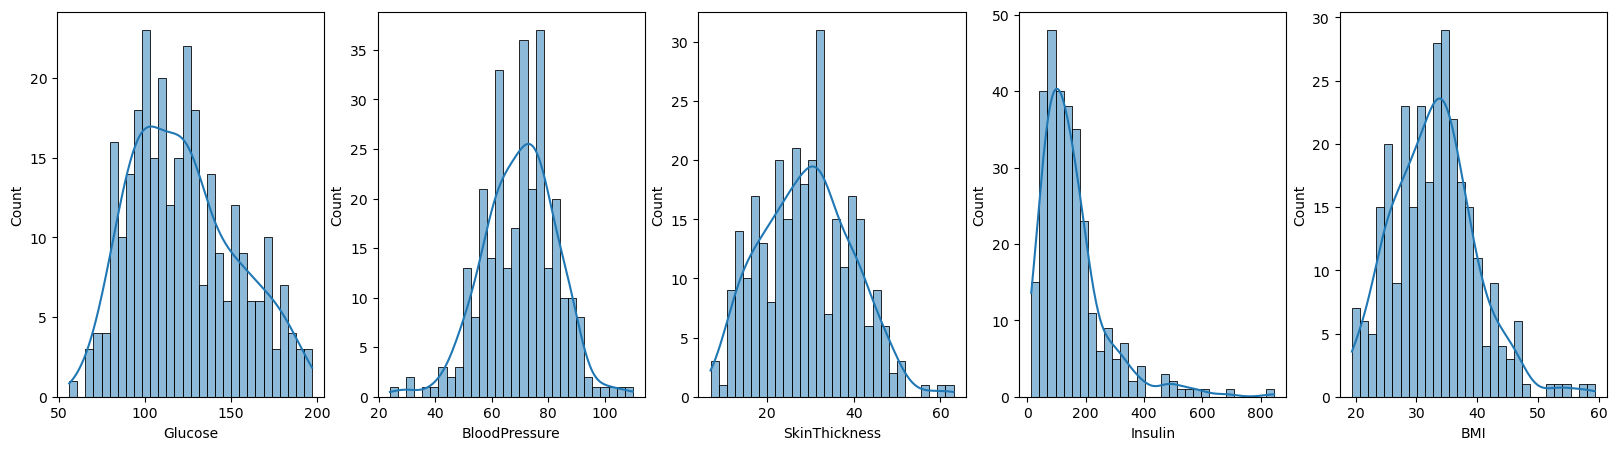

In [49]:
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(20,5))
axs = axs.flatten()

for i, col in enumerate(columns_to_fill):
    sns.histplot(X_train[col], bins=30, kde=True, ax=axs[i])
plt.show()

## Scaling

In [50]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [51]:
results = []

for i in range(len(list(models))):
    model = list(models.values())[i]
    model.fit(X_train, y_train)

    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    model_train_acc, model_train_conf_matrix, model_train_clf_report = calculate_model_metrics(y_train, y_train_pred)
    model_test_acc, model_test_conf_matrix, model_test_clf_report = calculate_model_metrics(y_test, y_test_pred)

    results.append(
        {
            "Model": list(models.keys())[i],
            "Train Accuracy": model_train_acc,
            "Test Accuracy": model_test_acc
        }
    )

In [52]:
df2_results = pd.DataFrame(results)

In [53]:
df2_results.sort_values(by="Test Accuracy", ascending=False).reset_index(drop=True)

,Model,Train Accuracy,Test Accuracy
0,AdaBoostClassifier,0.857143,0.806122
1,RandomForestClassifier,1.000000,0.795918
2,LogisticRegression,0.799320,0.785714
3,GaussianNB,0.761905,0.785714
4,SVC,0.850340,0.775510
5,KNeighborsClassifier,0.823129,0.765306
6,DecisionTreeClassifier,1.000000,0.683673


## Hyperparameter Tuning

In [54]:
logistic_regression_params = {"penalty": ["l1", "l2"], "C": [1, 0.1, 0.01], "solver": ["liblinear", "saga"]}
svc_params = {"C": [0.1, 1, 10], "kernel": ["linear", "rbf"], "gamma": ["scale", "auto"]}
knn_params = {"n_neighbors": [3, 5, 7], "weights": ["uniform", "distance"], "p": [1, 2], "algorithm": ["auto"]}
decision_tree_params = {"criterion": ["gini", "entropy"], "splitter": ["best"], "max_depth": [5, 10, 15], "max_features": ["sqrt", "log2"], "min_samples_split": [5, 10]}
random_forest_params = {"max_depth": [5, 10], "max_features": ["sqrt", "log2"], "min_samples_split": [5, 10], "n_estimators": [50, 100, 200]}
adaboost_params = { "n_estimators": [50, 100], "learning_rate": [0.01, 0.1]}

In [55]:
params = {
    'LogisticRegression': logistic_regression_params,
    'SVC': svc_params,
    'KNeighborsClassifier': knn_params,
    'DecisionTreeClassifier': decision_tree_params,
    'RandomForestClassifier': random_forest_params,
    'AdaBoostClassifier' : adaboost_params
}

In [56]:
best_models = {}
tuned_results = []

for name, model in models.items():
    if name in params:
        grid = GridSearchCV(estimator=model, param_grid=params[name], cv=5, scoring='accuracy', n_jobs=-1)
        grid.fit(X_train, y_train)

        
        best_model = grid.best_estimator_
        best_models[name] = best_model
        
        y_train_pred = best_model.predict(X_train)
        y_test_pred = best_model.predict(X_test)
        
        model_train_ac, _,_ = calculate_model_metrics(y_train, y_train_pred)
        model_test_ac, _,_ = calculate_model_metrics(y_test, y_test_pred)

        tuned_results.append({
            "Model": name,
            "Best Params": grid.best_params_,
            "Train Accuracy": model_train_ac,
            "Test Accuracy": model_test_ac
        })


In [57]:
df2_results_grid = pd.DataFrame(tuned_results)

In [58]:
df2_results_grid.sort_values(by="Test Accuracy", ascending=False).reset_index(drop=True)

,Model,Best Params,Train Accuracy,Test Accuracy
0,RandomForestClassifier,"{'max_depth': 10, 'max_features': 'log2', 'min...",0.993197,0.836735
1,AdaBoostClassifier,"{'learning_rate': 0.1, 'n_estimators': 50}",0.819728,0.806122
2,SVC,"{'C': 10, 'gamma': 'scale', 'kernel': 'linear'}",0.795918,0.785714
3,LogisticRegression,"{'C': 1, 'penalty': 'l1', 'solver': 'saga'}",0.799320,0.785714
4,DecisionTreeClassifier,"{'criterion': 'gini', 'max_depth': 5, 'max_fea...",0.829932,0.755102
5,KNeighborsClassifier,"{'algorithm': 'auto', 'n_neighbors': 7, 'p': 1...",0.806122,0.744898


Based on the second model results, AdaBoost, Logistic Regression, and SVC continued to deliver balanced and reliable performance, maintaining close accuracy scores across training and test sets.

In contrast, Decision Tree and Random Forest still showed signs of overfitting, with high training accuracy and a noticeable decline in test performance, despite the use of an alternative preprocessing strategy.

## Evaluation of the Results

In [59]:
df_merged = pd.merge(df1_results, df2_results, on='Model', how='inner')

In [65]:
df_merged.columns = ["Model", "1.Model_Train_Accuracy", "1.Model_Test_Accuracy", "2.Model_Train_Accuracy", "2.Model_Test_Accuracy"]

In [67]:
df_merged

,Model,1.Model_Train_Accuracy,1.Model_Test_Accuracy,2.Model_Train_Accuracy,2.Model_Test_Accuracy
0,LogisticRegression,0.783388,0.753247,0.799320,0.785714
1,SVC,0.838762,0.727273,0.850340,0.775510
2,GaussianNB,0.765472,0.720779,0.761905,0.785714
3,KNeighborsClassifier,0.830619,0.694805,0.823129,0.765306
4,DecisionTreeClassifier,1.000000,0.701299,1.000000,0.683673
5,RandomForestClassifier,1.000000,0.733766,1.000000,0.795918
6,AdaBoostClassifier,0.786645,0.753247,0.857143,0.806122


- Overall, Model 2 (the approach where rows containing zero values were removed from the dataset) yielded better test accuracy. In particular, AdaBoostClassifier (80.6%) and LogisticRegression (78.5%) stood out with strong performance.
- Both DecisionTreeClassifier and RandomForestClassifier showed clear signs of overfitting in both models, achieving 100% training accuracy while test accuracy remained significantly lower.
- Model 1, which used median imputation to replace zero values, allowed for more data to be used. However, this increased the risk of overfitting, especially in more complex models.
- For simpler models like GaussianNB, no meaningful difference was observed between the two preprocessing approaches.

In [61]:
df_merged_tuning = pd.merge(df1_results_rcv, df2_results_grid, on='Model', how='inner')

In [75]:
df_merged_tuning.columns = ['Model', 'Best Params_(Model1)', 'Train Accuracy_(Model1)', 'Test Accuracy_(Model1)',
       'Best Params_(Model2)', 'Train Accuracy_(Model2)', 'Test Accuracy_(Model2)']

In [76]:
df_merged_tuning

,Model,Best Params_(Model1),Train Accuracy_(Model1),Test Accuracy_(Model1),Best Params_(Model2),Train Accuracy_(Model2),Test Accuracy_(Model2)
0,LogisticRegression,"{'solver': 'liblinear', 'penalty': 'l1', 'C': 1}",0.781759,0.759740,"{'C': 1, 'penalty': 'l1', 'solver': 'saga'}",0.799320,0.785714
1,SVC,"{'kernel': 'sigmoid', 'gamma': 'scale', 'degre...",0.765472,0.753247,"{'C': 10, 'gamma': 'scale', 'kernel': 'linear'}",0.795918,0.785714
2,KNeighborsClassifier,"{'weights': 'distance', 'p': 1, 'n_neighbors':...",1.000000,0.740260,"{'algorithm': 'auto', 'n_neighbors': 7, 'p': 1...",0.806122,0.744898
3,DecisionTreeClassifier,"{'splitter': 'best', 'min_samples_split': 10, ...",0.845277,0.714286,"{'criterion': 'gini', 'max_depth': 5, 'max_fea...",0.829932,0.755102
4,RandomForestClassifier,"{'n_estimators': 500, 'min_samples_split': 8, ...",0.964169,0.720779,"{'max_depth': 10, 'max_features': 'log2', 'min...",0.993197,0.836735
5,AdaBoostClassifier,"{'n_estimators': 120, 'learning_rate': 1}",0.815961,0.759740,"{'learning_rate': 0.1, 'n_estimators': 50}",0.819728,0.806122
